<a href="https://colab.research.google.com/github/wj-arit/FewShotLearning-with-PyTorch/blob/main/FSL(Siamese%2Bomniglot).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 9.46M/9.46M [00:00<00:00, 534MB/s]


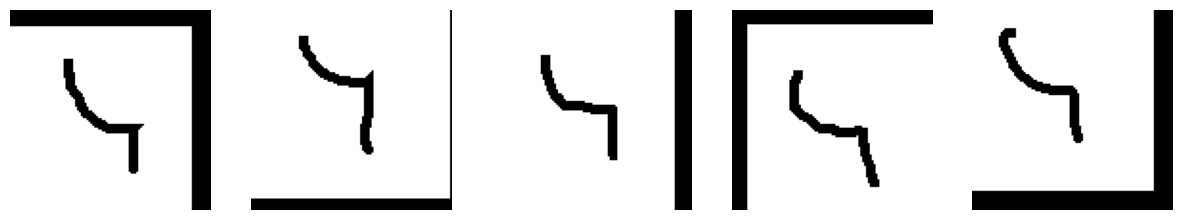

In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, root="./data", background=True):
        """
        background=True  → training split (30 alphabets)
        background=False → evaluation split (20 alphabets)
        """

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # 1채널 유지
            transforms.Resize((105, 105)),  # 원 논문 크기

            transforms.RandomApply([
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1)),

            ],p=1),
            transforms.ToTensor()
        ])

        self.dataset = datasets.Omniglot(
            root=root,
            background=background,   # train이 아니라 background
            download=True,
            transform=self.transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label



if __name__ == "__main__":
    train_base = OmniglotDataset(background=True)
    check = []
    for i in range(5):
        check.append(train_base.dataset[i][0])
    plt.figure(figsize=(15, 3))
    for idx, img in enumerate(check):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img.permute(1, 2, 0), cmap='gray')
        plt.axis('off')

    plt.show()






In [ ]:
class FewShotDataset:
    """
    클래스별 인덱스를 만들어서 EpisodeSampler가 가져다 쓰게 하는 클래스
    """
    def __init__(self, base_dataset: Dataset):
        self.base_dataset = base_dataset

        # {클래스: [해당 클래스에 속하는 인덱스들]}
        # class_to_indices변수에 클래스번호를 키 클래스별 데이터 인덱스를 리스트형식으로 딕셔너리 만들기 위해 선언
        self.class_to_indices = defaultdict(list)

        for idx in range(len(self.base_dataset)):
            _, label = self.base_dataset[idx]
            self.class_to_indices[label].append(idx)

        self.classes = sorted(list(self.class_to_indices.keys()))

    def sample_indices(self, cls, num):
        return random.sample(self.class_to_indices[cls], num)

    def __getitem__(self, idx):
        return self.base_dataset[idx]

    def __len__(self):
        return len(self.base_dataset)
if __name__ == '__main__':
  a = FewShotDataset(OmniglotDataset(background=True))
  #print(a.sample_indices(39,7))
  print(len(a.classes))
  #print(a.class_to_indices)

964


In [ ]:
class EpisodeSampler:
    """
    N-way, K-shot, Q-query 생성기
    """
    def __init__(self, fewshot_dataset: FewShotDataset,
                 n_way=10, k_shot=1, q_query=15):
        self.fs = fewshot_dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query

    def create_episode(self):
        selected_classes = random.sample(self.fs.classes, self.n_way)

        support_indices = []
        query_indices = []

        for cls in selected_classes:
            all_indices = self.fs.sample_indices(cls, self.k_shot + self.q_query)
            support = all_indices[:self.k_shot]
            query   = all_indices[self.k_shot:]

            support_indices.extend([(idx, cls) for idx in support])
            query_indices.extend([(idx, cls) for idx in query])

        return support_indices, query_indices




In [ ]:
class FewShotDataloader:
    """
    EpisodeSampler를 이용해 episode 단위로 데이터를 제공
    """
    def __init__(self, base_dataset, sampler: EpisodeSampler, episodes_per_epoch=200):
        self.base_dataset = base_dataset
        self.sampler = sampler
        self.episodes_per_epoch = episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            support_indices, query_indices = self.sampler.create_episode()

            support_set = [(self.base_dataset[i], label) for (i, label) in support_indices]
            query_set = [(self.base_dataset[i], label) for (i, label) in query_indices]

            yield support_set, query_set

    def __len__(self):
        return self.episodes_per_epoch






========== FewShotDataloader 테스트 시작 ==========

--- Episode 0 ---
[CHECK] Support size = 10 (expected 10)
[CHECK] Query size   = 150 (expected 150)

--- Support Sample Info ---
0) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195
1) img.shape=torch.Size([1, 105, 105]), global_label=188, episode_label=188
2) img.shape=torch.Size([1, 105, 105]), global_label=453, episode_label=453
3) img.shape=torch.Size([1, 105, 105]), global_label=645, episode_label=645
4) img.shape=torch.Size([1, 105, 105]), global_label=727, episode_label=727

--- Query Sample Info ---
0) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195
1) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195
2) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195
3) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195
4) img.shape=torch.Size([1, 105, 105]), global_label=195, episode_label=195

Support episode labels: [188, 195,

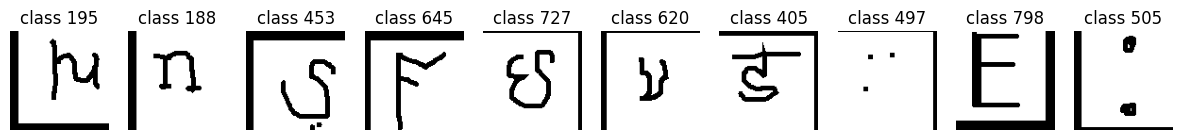


========== FewShotDataloader 테스트 완료 ==========



In [ ]:
import matplotlib.pyplot as plt

def test_fewshot_dataloader(dataloader, sampler, show_images=False):

    print("\n========== FewShotDataloader 테스트 시작 ==========\n")

    # sampler 설정값 가져옴
    N = sampler.n_way
    K = sampler.k_shot
    Q = sampler.q_query

    # 에피소드 하나만 테스트
    for ep_idx, (support_set, query_set) in enumerate(dataloader):

        print(f"--- Episode {ep_idx} ---")

        # 1) support/query 크기 검사
        print(f"[CHECK] Support size = {len(support_set)} (expected {N*K})")
        print(f"[CHECK] Query size   = {len(query_set)} (expected {N*Q})")

        # 2) support 예시 출력
        print("\n--- Support Sample Info ---")
        for i, (data, ep_label) in enumerate(support_set[:min(5, len(support_set))]):
            img, global_label = data
            print(f"{i}) img.shape={img.shape}, global_label={global_label}, episode_label={ep_label}")

        # 3) query 예시 출력
        print("\n--- Query Sample Info ---")
        for i, (data, ep_label) in enumerate(query_set[:min(5, len(query_set))]):
            img, global_label = data
            print(f"{i}) img.shape={img.shape}, global_label={global_label}, episode_label={ep_label}")

        # 4) support/query episode label 분포 확인
        support_labels = sorted(list(set([label for (_, label) in support_set])))
        query_labels = sorted(list(set([label for (_, label) in query_set])))

        print("\nSupport episode labels:", support_labels)
        print("Query episode labels:  ", query_labels)

        # 5) optional: support 이미지를 matplotlib로 시각화
        if show_images:
            plt.figure(figsize=(15, 3))
            for i, (data, ep_label) in enumerate(support_set[:min(N, len(support_set))]):
                img, global_label = data
                plt.subplot(1, N, i+1)
                plt.imshow(img.permute(1,2,0), cmap='gray')
                plt.title(f"class {ep_label}")
                plt.axis('off')
            plt.show()

        break   # 첫 episode만 확인하고 종료

    print("\n========== FewShotDataloader 테스트 완료 ==========\n")
if __name__ == '__main__':
    a = OmniglotDataset(background=True)
    b = FewShotDataset(a)
    c = EpisodeSampler(b)
    d = FewShotDataloader(a,c)
    test_fewshot_dataloader(d,c,show_images=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNetBackbone(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, out_dim)

    def forward(self, x):
        return self.model(x)


class SiameseNetwork(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(128, 1)
        #self.weight_initialization()

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward_once(self, x):
        return self.backbone(x)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        dist = torch.abs(out1 - out2)
        logit = self.fc(dist)

        return logit


if __name__ == '__main__':
    a = ResNetBackbone()
    print(a)


ResNetBackbone(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
def generate_pairs_from_episode(support_set, query_set):
    pairs_1 = []
    pairs_2 = []
    labels = []

    # support_set: ((img, global_label), episode_label)
    support_dict = {}
    for (s_data, s_ep) in support_set:
        s_img, _ = s_data
        support_dict[s_ep] = s_img

    for (q_data, q_ep) in query_set:
        q_img, _ = q_data

        # Positive
        s_img_pos = support_dict[q_ep]
        pairs_1.append(q_img)
        pairs_2.append(s_img_pos)
        labels.append(0)

        # Negative
        neg_classes = [ep for ep in support_dict.keys() if ep != q_ep]
        neg_class = random.choice(neg_classes)
        s_img_neg = support_dict[neg_class]
        pairs_1.append(q_img)
        pairs_2.append(s_img_neg)
        labels.append(1)

    return torch.stack(pairs_1), torch.stack(pairs_2), torch.tensor(labels)


if __name__ == '__main__':
    # ==============================================
    # generate_pairs_from_episode 디버깅 코드
    # ==============================================
    base = OmniglotDataset(background=True)
    fs = FewShotDataset(base)
    sampler = EpisodeSampler(fs, n_way=10, k_shot=1, q_query=15)
    loader = FewShotDataloader(base, sampler)

    support_set, query_set = next(iter(loader))
    x1, x2, labels = generate_pairs_from_episode(support_set, query_set)


    print("=== Pair Generation Debug ===")

    print("Support set size:", len(support_set))
    print("Query set size:", len(query_set))
    print("Pairs generated:", len(labels))

    # 라벨 통계 확인
    unique, counts = labels.unique(return_counts=True)
    print("Label distribution:")
    for u, c in zip(unique, counts):
        print(f"  Label {u.item()}: {c.item()} 개")

    # Shape 체크
    print("x1 shape:", x1.shape)
    print("x2 shape:", x2.shape)
    print("labels shape:", labels.shape)

    # 앞의 몇 개 출력
    print("\nFirst 5 pairs:")
    for i in range(5):
        print(f"  label={labels[i].item()}, x1 min={x1[i].min().item():.3f}, max={x1[i].max().item():.3f}")

    # episode label 확인
    print("\nEpisode labels in support set:")
    print([ep for (_, _), ep in support_set[:5]])

    print("Episode labels in query set:")
    print([ep for (_, _), ep in query_set[:5]])
    print("All query episode labels distribution:")
    q_labels = [ep for (_, _), ep in query_set]
    print(sorted(list(set(q_labels))))




=== Pair Generation Debug ===
Support set size: 10
Query set size: 150
Pairs generated: 300
Label distribution:
  Label 0: 150 개
  Label 1: 150 개
x1 shape: torch.Size([300, 1, 105, 105])
x2 shape: torch.Size([300, 1, 105, 105])
labels shape: torch.Size([300])

First 5 pairs:
  label=0, x1 min=-10.943, max=0.925
  label=1, x1 min=-10.943, max=0.925
  label=0, x1 min=-10.943, max=0.925
  label=1, x1 min=-10.943, max=0.925
  label=0, x1 min=-10.943, max=0.925

Episode labels in support set:
[69, 485, 205, 369, 105]
Episode labels in query set:
[69, 69, 69, 69, 69]
All query episode labels distribution:
[69, 105, 126, 205, 245, 369, 386, 485, 778, 895]


In [ ]:
import csv
import os

class Logger:
    def __init__(self, log_path="training_log.csv"):
        self.log_path = log_path

        # CSV 헤더 생성
        with open(self.log_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["epoch", "train_loss", "test_acc"])

    def write(self, epoch, train_loss, test_acc):
        with open(self.log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, test_acc])


In [ ]:

def train_siamese(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for support_set, query_set in tqdm(dataloader, desc="Training"):
        x1, x2, labels = generate_pairs_from_episode(support_set, query_set)
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

        similarity = model(x1, x2)
        loss = criterion(similarity,labels.to(torch.float32).float().unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss / len(dataloader)



'\ndef train_siamese(model, dataloader, optimizer, criterion, device):\n    model.train()\n    total_loss = 0\n\n    for i, (support_set, query_set) in enumerate(tqdm(dataloader, desc="Training")):\n        x1, x2, labels = generate_pairs_from_episode(support_set, query_set)\n        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)\n\n        # ★ 최초 1회만 디버깅\n        if i == 0:\n            print("\n========== DEBUG ==========")\n\n            # 1) backbone output shape\n            tmp = model.backbone(x1[:4])\n            print("backbone output shape:", tmp.shape)\n\n            # 2) siamese individual output shapes\n            out1 = model.backbone(x1[:4])\n            out2 = model.backbone(x2[:4])\n            print("out1:", out1.shape)\n            print("out2:", out2.shape)\n\n            # 3) dist shape\n            dist = torch.abs(out1 - out2)\n            print("dist:", dist.shape)\n\n            # 4) check NaN / Inf\n            print("NaN in out1?", torch.is

In [ ]:
def test_siamese(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for support_set, query_set in tqdm(dataloader, desc='Testing'):

            support_dict = {}
            for (data, ep_label) in support_set:
                img, _ = data
                img = img.unsqueeze(0).to(device)
                emb = model.backbone(img)
                support_dict[ep_label] = emb

            for (data, ep_label) in query_set:
                img, _ = data
                img = img.unsqueeze(0).to(device)
                q_emb = model.backbone(img)

                sims = {}
                for cls, s_emb in support_dict.items():
                    dist = torch.abs(q_emb - s_emb)
                    logit = model.fc(dist)

                    # logit이 작을수록 "유사" (label=0)
                    sims[cls] = logit.item()

                pred = min(sims, key=sims.get)   #

                correct += (pred == ep_label)
                total += 1

    return correct / total




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset 구성
train_base = OmniglotDataset(background=True)
test_base  = OmniglotDataset(background=False)

fs_train = FewShotDataset(train_base)
fs_test  = FewShotDataset(test_base)

sampler_train = EpisodeSampler(fs_train, n_way=10, k_shot=1, q_query=15)
sampler_test  = EpisodeSampler(fs_test,  n_way=10, k_shot=1, q_query=15)

train_loader = FewShotDataloader(train_base, sampler_train, episodes_per_epoch=300)
test_loader  = FewShotDataloader(test_base,  sampler_test,  episodes_per_epoch=50)




# 모델, 옵티마이저
backbone = ResNetBackbone(out_dim=128)
model = SiameseNetwork(backbone).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
    )

# 로그 저장
logger = Logger("training_log.csv")

# 베스트 모델 저장 관련 변수
best_acc = 0.0
best_path = "best_siamese_model.pth"


# 학습 시작
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    print(f"\n========== Epoch {epoch}/{num_epochs} ==========")

    train_loss = train_siamese(model, train_loader, optimizer, criterion, device)
    test_acc   = test_siamese(model, test_loader, device)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

    # 로그 저장
    logger.write(epoch, train_loss, test_acc)

    # 베스트 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), best_path)
        print(f" Best model updated! Saved to {best_path}")




========== Epoch 1/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 1] Train Loss: 0.5264 | Test Acc: 32.24%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 2/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 2] Train Loss: 0.4231 | Test Acc: 49.83%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 3/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 3] Train Loss: 0.3091 | Test Acc: 69.03%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 4/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 4] Train Loss: 0.2554 | Test Acc: 70.49%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 5/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 5] Train Loss: 0.2200 | Test Acc: 77.72%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 6/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 6] Train Loss: 0.1695 | Test Acc: 80.39%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 7/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 7] Train Loss: 0.1528 | Test Acc: 84.07%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 8/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 8] Train Loss: 0.1404 | Test Acc: 83.51%

========== Epoch 9/200 ==========


Testing: 100%|██████████| 50/50 [00:31<00:00,  1.56it/s]


[Epoch 9] Train Loss: 0.1254 | Test Acc: 86.59%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 10/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 10] Train Loss: 0.1151 | Test Acc: 85.95%

========== Epoch 11/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 11] Train Loss: 0.1089 | Test Acc: 88.27%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 12/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 12] Train Loss: 0.1022 | Test Acc: 88.15%

========== Epoch 13/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 13] Train Loss: 0.1008 | Test Acc: 87.95%

========== Epoch 14/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 14] Train Loss: 0.0845 | Test Acc: 90.53%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 15/200 ==========


Testing: 100%|██████████| 50/50 [00:31<00:00,  1.56it/s]


[Epoch 15] Train Loss: 0.0835 | Test Acc: 90.60%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 16/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 16] Train Loss: 0.0816 | Test Acc: 92.53%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 17/200 ==========


Testing: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


[Epoch 17] Train Loss: 0.0757 | Test Acc: 89.72%

========== Epoch 18/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


[Epoch 18] Train Loss: 0.0768 | Test Acc: 90.12%

========== Epoch 19/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 19] Train Loss: 0.0716 | Test Acc: 92.29%

========== Epoch 20/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 20] Train Loss: 0.0644 | Test Acc: 92.63%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 21/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 21] Train Loss: 0.0605 | Test Acc: 93.15%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 22/200 ==========


Testing: 100%|██████████| 50/50 [00:31<00:00,  1.56it/s]


[Epoch 22] Train Loss: 0.0626 | Test Acc: 90.12%

========== Epoch 23/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 23] Train Loss: 0.0611 | Test Acc: 92.56%

========== Epoch 24/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 24] Train Loss: 0.0575 | Test Acc: 92.20%

========== Epoch 25/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 25] Train Loss: 0.0554 | Test Acc: 92.57%

========== Epoch 26/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 26] Train Loss: 0.0594 | Test Acc: 93.73%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 27/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 27] Train Loss: 0.0545 | Test Acc: 92.55%

========== Epoch 28/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 28] Train Loss: 0.0499 | Test Acc: 93.75%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 29/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 29] Train Loss: 0.0524 | Test Acc: 93.77%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 30/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 30] Train Loss: 0.0515 | Test Acc: 93.12%

========== Epoch 31/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 31] Train Loss: 0.0461 | Test Acc: 93.83%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 32/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


[Epoch 32] Train Loss: 0.0483 | Test Acc: 93.20%

========== Epoch 33/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 33] Train Loss: 0.0481 | Test Acc: 93.44%

========== Epoch 34/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 34] Train Loss: 0.0455 | Test Acc: 95.01%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 35/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 35] Train Loss: 0.0434 | Test Acc: 94.59%

========== Epoch 36/200 ==========


Testing: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


[Epoch 36] Train Loss: 0.0465 | Test Acc: 94.25%

========== Epoch 37/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 37] Train Loss: 0.0411 | Test Acc: 92.88%

========== Epoch 38/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 38] Train Loss: 0.0404 | Test Acc: 94.39%

========== Epoch 39/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 39] Train Loss: 0.0443 | Test Acc: 93.79%

========== Epoch 40/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 40] Train Loss: 0.0423 | Test Acc: 93.04%

========== Epoch 41/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 41] Train Loss: 0.0435 | Test Acc: 93.44%

========== Epoch 42/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 42] Train Loss: 0.0418 | Test Acc: 92.84%

========== Epoch 43/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 43] Train Loss: 0.0392 | Test Acc: 94.81%

========== Epoch 44/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 44] Train Loss: 0.0361 | Test Acc: 93.87%

========== Epoch 45/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 45] Train Loss: 0.0374 | Test Acc: 93.71%

========== Epoch 46/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


[Epoch 46] Train Loss: 0.0352 | Test Acc: 94.45%

========== Epoch 47/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 47] Train Loss: 0.0347 | Test Acc: 95.20%
 Best model updated! Saved to best_siamese_model.pth

========== Epoch 48/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 48] Train Loss: 0.0327 | Test Acc: 94.73%

========== Epoch 49/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 49] Train Loss: 0.0342 | Test Acc: 94.47%

========== Epoch 50/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 50] Train Loss: 0.0325 | Test Acc: 93.41%

========== Epoch 51/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 51] Train Loss: 0.0328 | Test Acc: 94.88%

========== Epoch 52/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 52] Train Loss: 0.0315 | Test Acc: 93.53%

========== Epoch 53/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 53] Train Loss: 0.0290 | Test Acc: 94.37%

========== Epoch 54/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 54] Train Loss: 0.0297 | Test Acc: 94.95%

========== Epoch 55/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 55] Train Loss: 0.0313 | Test Acc: 94.13%

========== Epoch 56/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 56] Train Loss: 0.0285 | Test Acc: 93.32%

========== Epoch 57/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 57] Train Loss: 0.0317 | Test Acc: 94.45%

========== Epoch 58/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 58] Train Loss: 0.0282 | Test Acc: 95.09%

========== Epoch 59/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 59] Train Loss: 0.0277 | Test Acc: 94.96%

========== Epoch 60/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 60] Train Loss: 0.0325 | Test Acc: 94.45%

========== Epoch 61/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 61] Train Loss: 0.0282 | Test Acc: 94.80%

========== Epoch 62/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


[Epoch 62] Train Loss: 0.0271 | Test Acc: 94.85%

========== Epoch 63/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 63] Train Loss: 0.0312 | Test Acc: 94.77%

========== Epoch 64/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 64] Train Loss: 0.0262 | Test Acc: 94.67%

========== Epoch 65/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 65] Train Loss: 0.0241 | Test Acc: 95.19%

========== Epoch 66/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 66] Train Loss: 0.0323 | Test Acc: 94.37%

========== Epoch 67/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 67] Train Loss: 0.0296 | Test Acc: 94.36%

========== Epoch 68/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 68] Train Loss: 0.0279 | Test Acc: 94.76%

========== Epoch 69/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


[Epoch 69] Train Loss: 0.0269 | Test Acc: 94.67%

========== Epoch 70/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


[Epoch 70] Train Loss: 0.0247 | Test Acc: 95.08%

========== Epoch 71/200 ==========


Testing: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


[Epoch 71] Train Loss: 0.0263 | Test Acc: 94.65%

========== Epoch 72/200 ==========


Training:  58%|█████▊    | 174/300 [00:47<00:34,  3.67it/s]


KeyboardInterrupt: 

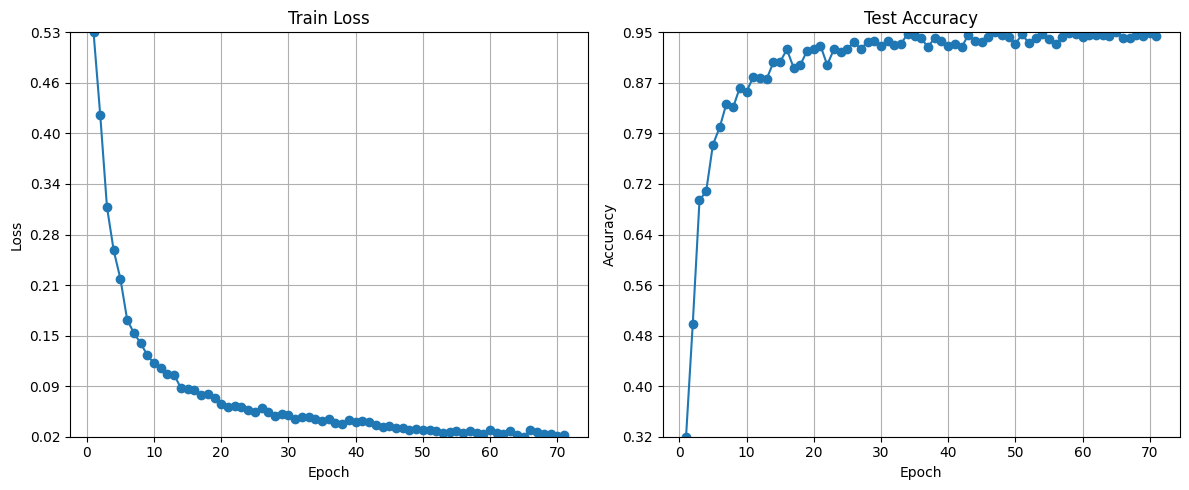

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

epochs = []
train_losses = []
test_accs = []

with open("/content/drive/MyDrive/SiameseNetwork/training_log.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        epochs.append(int(row["epoch"]))
        train_losses.append(float(row["train_loss"]))
        test_accs.append(float(row["test_acc"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

formatter = FormatStrFormatter('%.2f')   # 소수 둘째자리 포매팅

# ====== Train Loss ======
axes[0].plot(epochs, train_losses, marker="o")
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

loss_min = min(train_losses)
loss_max = max(train_losses)

axes[0].set_ylim(loss_min, loss_max)

# ★ Y축 tick 9개 (min~max 사이 등간격 9개)
loss_ticks = np.linspace(loss_min, loss_max, 9)
axes[0].set_yticks(loss_ticks)
axes[0].yaxis.set_major_formatter(formatter)

axes[0].grid(True)


# ====== Test Accuracy ======
axes[1].plot(epochs, test_accs, marker="o")
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

acc_min = min(test_accs)
acc_max = max(test_accs)

axes[1].set_ylim(acc_min, acc_max)

# ★ Y축 tick 9개 (min~max 사이 등간격)
acc_ticks = np.linspace(acc_min, acc_max, 9)
axes[1].set_yticks(acc_ticks)
axes[1].yaxis.set_major_formatter(formatter)

axes[1].grid(True)


plt.tight_layout()
plt.show()

